In [92]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [93]:
%matplotlib inline

# `Ridge Regression`

### ------------------------------------------------------------------------------------------------

# Overview 

 **Goal**: predict the behavior of a continuous _endogenous_ variable given its corresponding _exogenous_ variables, under the constraint that we are penalizing based on coefficient magnitudes when solving for said coefficients. This setup allows for models that are less prone to over-fitting than simple OLS models are.
 
 **Model**: $y = X{\beta} + {\epsilon}$

**Terms**:
- $y$: vector of endogenous values
- $X$: matrix of exogenous values
- $\beta$: vector of coefficients for exogenous variables
- $\epsilon$: a representation of the random errors or fluctuations around the predicted line or plane

**Functionality**:
- $y$ is the result of taking the matrix product of $\beta$ and $X$
- i.e. each row in $y$ is the sum of the products, for that row, of each value of $X$ with its corresponding $\beta$

**Basic example**:
- *endogenous*: price of an apartment
- *exogenous*: square footage (1), number of rooms (2)
- $y = \beta_{0} + \beta_{1} * X_{1} + \beta_{2} * X_{2} + \epsilon$
- i.e. $constant + coefficient_{1} * area + coefficient_{2} * rooms$

### ------------------------------------------------------------------------------------------------

# Tikhonov regularization

$\displaystyle \min _{\beta }\,(\mathbf {y} -\mathbf {X} \beta )^{\mathsf {T}}(\mathbf {y} -\mathbf {X} \beta )+\lambda (\beta ^{\mathsf {T}}\beta -c)$

$\displaystyle {\hat {\beta }}_{R}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y}$

### ------------------------------------------------------------------------------------------------

# Parameter Estimation - OLS

**Goal**: given $X$ and $y$, find $\beta$

**Method**: there exist many ways to reach our goal - we will start with Ordinary Least Squares (OLS)

(notes written with support from [Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares) and [ESL](http://web.stanford.edu/~hastie/ElemStatLearn/))

### Background

- to measure the distance between a response and a predicted response, one can take the difference between the two values
- this would be written as, for the $i^{th}$ data point, $y_{i} - {X_{i}}\beta$ (note that $X_{i}$ is a row of $X$), and is referred to as the _residual_ for this data point

### Overall model fit

- summing the squares of all residuals provides a measure of overall model fit
- sum of squared residuals: $\sum_{i=1}^{n}(y_{i} - \sum_{j=1}^{p}{X_{i, j}\beta_{j})}^{2} = {(y-X\beta)}^{T}(y-X\beta)$

### Estimate Beta

- if we find the values of $\beta$ that minimize the sum of the squared residuals, we have found the model coefficients that provide the best fit
- to find the values of $\beta$ that minimize ${(y-X\beta)}^{T}(y-X\beta)$ we need to first differentiate with respect to $\beta$, yielding a first derivative $-2X^{T}(y - X\beta)$
- if we set that first derivate equal to 0, $X^{T}(y - X\beta) = 0$, we can, making some assumptions, solve to:

$$\hat\beta = (X^{T}X)^{-1}X^{T}y$$

- see more on the derivation of OLS regression [here](https://are.berkeley.edu/courses/EEP118/current/derive_ols.pdf)

### Evaluation

- a commonly used metric for fit assessment is that of $R^{2}$
- this is the ratio of the variance of $\hat{y}$ around the mean of $y$, $\bar{y}$, to the variance of $y$, i.e. the ratio of "explained" to "total" variance of $y$
- which is written as $\large\frac{\sum(\hat{y} - \bar{y})^{2}}{\sum(y - \bar{y})^{2}}$
- useful use of this metric requires the model to include a constant, or $\beta_{0}$, term, in which case 0 < $R^{2}$ < 1, with closer to 1 being better

### ------------------------------------------------------------------------------------------------

# Implementation

In [9]:
class RidgeRegressor:
    """Ridge Regression class, built for NumPy arrays. 
    Fits using lin alg. Always supplies a constant coefficient.
    Very unstable!
    
    (subbing in `alpha` for `lambda` due to the latter's protected status)
    """
    
    def __init__(self, alpha=1):
        self.X = None
        self.y = None
        self.B = None
        self.alpha = alpha
        self.y_hat = None
        
    
    def fit(self, X, y):
        for_coeff = np.ones((X.shape[0], 1))
        X = np.hstack((X, for_coeff))

        self.B = np.linalg.inv(X.T.dot(X) + self.alpha * np.identity(X.shape[1])).dot(X.T).dot(y)
        self.X = X
        self.y = y
    
    
    def predict(self, X):
        if self.B is None:
            return None
        self.y_hat = self.X.dot(self.B)
        return self.y_hat

    
    def r_sqrd(self):
        if self.y is None:
            return None
        elif self.y_hat is None:
            y_hat = self.predict()
            
        y_bar = np.mean(self.y)
        explained = np.sum(np.power(self.y_hat - y_bar, 2))
        total = np.sum(np.power(self.y - y_bar, 2))
        return explained / total

### ------------------------------------------------------------------------------------------------

# Testing

### Generate Fake Data

- with `Ridge`, we are looking to prevent overfitting
- overfitting can happen when a model is too tightly coupled to the sample of the data that it happens to be trained on
- so, to do this right, we need an idea of what the distribution of our population looks like
- then, we need to draw sub-samples that do not represent the population very well

In [10]:
X = np.array([[np.random.normal(loc=_, scale=(_ + 1)) for _ in range(100)] for _ in range(3)])

In [11]:
X = X.T

In [12]:
y = np.array([np.random.normal() for _ in range(100)])

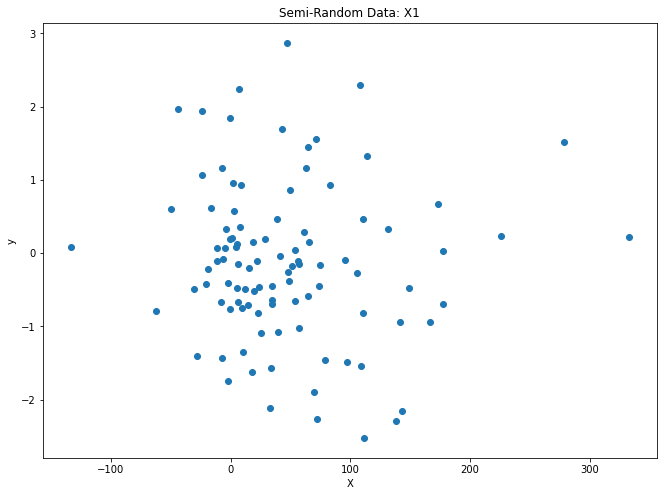

In [13]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(X[:, 0], y)
plt.xlabel("X")
plt.ylabel("y")
t = plt.title("Semi-Random Data: X1")

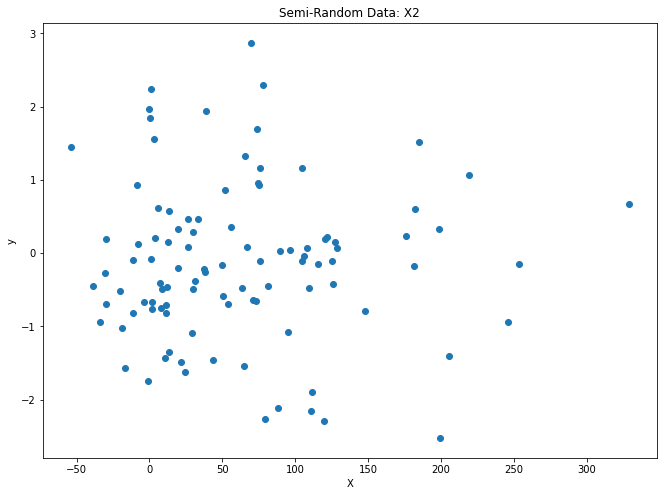

In [14]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(X[:, 1], y)
plt.xlabel("X")
plt.ylabel("y")
t = plt.title("Semi-Random Data: X2")

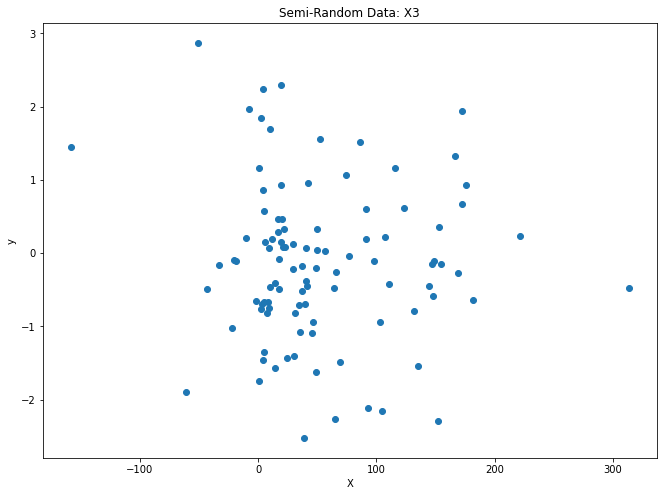

In [15]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(X[:, 2], y)
plt.xlabel("X")
plt.ylabel("y")
t = plt.title("Semi-Random Data: X3")

In [16]:
np.linalg.inv(X.T.dot(X) + np.identity(X.shape[1])).dot(X.T).dot(y)

array([-9.36122828e-04,  2.58333355e-06, -1.08926614e-03])

In [31]:
ridge = RidgeRegressor()

In [32]:
ridge.fit(X, y)

In [33]:
y_hat = ridge.predict(X)

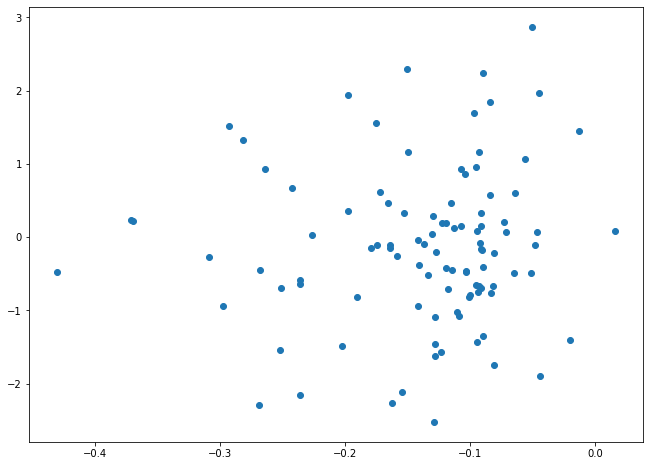

In [20]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(y_hat, y)

In [21]:
ridge.r_sqrd()

0.005602537701886559

## Testing on sklearn ridge regression

In [22]:
clf = Ridge(alpha=1.0)
clf.fit(X, y)

Ridge()

In [23]:
y_hat2 = clf.predict(X)

In [29]:
clf.score(X,y)

0.0055199353084790515

In [44]:
(y_hat - y_hat2).sum()

0.08189113378348455

## Testing on real data
- Insurance data can be find [here](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv)
- Independent variables: `age`, `sex`, `bmi`, `children`,`smoker`,`region`
- Dependent variables: `charges`

In [47]:
url ="https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

In [48]:
insurance_data = pd.read_csv(url)

In [49]:
insurance_data.shape

(1338, 7)

In [50]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 1 EDA

In [51]:
insurance_data.duplicated().sum()

1

In [52]:
insurance_data = insurance_data.drop_duplicates()

In [53]:
insurance_data.duplicated().sum()

0

In [54]:
insurance_data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [58]:
insurance_data.sex.value_counts()

male      675
female    662
Name: sex, dtype: int64

In [59]:
insurance_data.children.value_counts()

0    573
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [60]:
insurance_data.smoker.value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [61]:
insurance_data.region.value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

### 2. One hot encoding

In [88]:
def get_modeling_df(one_hot_cols, df):
    one_hot_df = []
    for col in one_hot_cols:
        temp = pd.get_dummies(df[col],prefix="is_{}".format(col))
        one_hot_df.append(temp)
    one_hot_df = pd.concat(one_hot_df,axis=1)
    return pd.concat([df.drop(columns=one_hot_cols),one_hot_df], axis=1)

In [89]:
one_hot_cols = ['sex','smoker','region']
insurance_for_modeling = get_modeling_df(one_hot_cols, insurance_data)

In [91]:
insurance_for_modeling.dtypes

age                      int64
bmi                    float64
children                 int64
charges                float64
is_sex_female            uint8
is_sex_male              uint8
is_smoker_no             uint8
is_smoker_yes            uint8
is_region_northeast      uint8
is_region_northwest      uint8
is_region_southeast      uint8
is_region_southwest      uint8
dtype: object

### 3. Modeling - Ridge

In [96]:
X = insurance_for_modeling[[i for i in insurance_for_modeling.columns if 'charges' not in i]]

In [98]:
y = insurance_for_modeling.charges

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [101]:
X_train.shape

(1069, 11)

In [113]:
def get_r_sqrd(alpha):
    ridge = RidgeRegressor(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(y_test)
    return ridge.r_sqrd()

In [114]:
get_r_sqrd(1)

0.7451372118143342

In [132]:
alpha_l = np.linspace(0.01,50,50)

In [133]:
rsq_l = [get_r_sqrd(i) for i in alpha_l]

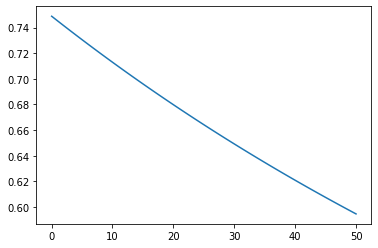

In [134]:
plt.plot(alpha_l,rsq_l)